In [1]:
import numpy as np
import os
from scipy import ndimage, signal
from matplotlib import pyplot as plt
import cv2
import pickle

import shutil

# This notebook is used to regenerate SC set from derived Grayset

In [2]:
# image functions
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img
def toGray(im, im_L=10, im_W=10, contrast=1.0):
    # normalize
    gray = np.zeros([im_L, im_W])
    for j in range(im_L):
        for i in range(im_W):
            gray[j][i] = max(im[j][i]) * contrast
    gray = convert(gray, 0, 255, np.uint8)
    return gray
def threshold(frame):
    out = np.full_like(frame, 128)
    out[frame < -6] = 0
    # out[frame > 4] = 255
    return out
kSC = np.array([[-1 / 8, -1 / 8, -1 / 8],  # from class material
                [-1 / 8, 1, -1 / 8],
                [-1 / 8, -1 / 8, -1 / 8]])
def SpatialContrast(imGray):
    conv_gray = signal.convolve2d(imGray, kSC, 'same')
    # print(conv_gray)
    fSCgray = np.array(threshold(conv_gray), dtype=np.uint8)
    return fSCgray

In [54]:
import random
num_tests = 10
contrast = .5

dirFROM = "ShapeGroups GRAY"
dirTO = "ShapeGroups"
SCset = np.empty([235, 10,10])
for root, dirs, files in os.walk(dirFROM):
    idx = 0
    for file in files:
        pathFROM = root + '\\' + file
        pathFROM = pathFROM.replace('\\', '/')
        pathTO = dirTO + '/' + pathFROM[17:]
        if pathFROM.find("shape3") != -1:
            im = convert(contrast*plt.imread(pathFROM), 0, 255, np.uint8)
            imSC = SpatialContrast(im)
            SCset[idx] = imSC
            idx = idx + 1

In [147]:
from sklearn.preprocessing import StandardScaler
dirFROM = "ShapeGroups GRAY/shape3"
set3 = np.empty([235, 10,10])
for root, dirs, files in os.walk(dirFROM):
    idx = 0
    for file in files:
        pathFROM = root + '\\' + file
        pathFROM = pathFROM.replace('\\', '/')
        pathTO = dirTO + '/' + pathFROM[17:]
        if pathFROM.find("shape3") != -1:
            im = convert(contrast*plt.imread(pathFROM), 0, 255, np.uint8)
            set3[idx] = im
            idx = idx + 1


set3new = np.copy(set3)
object = StandardScaler()
fit = object.fit_transform(set3[:][5][5].reshape(-1,1))
print(fit)
# for col in range(np.shape(set3)[1]):
#     for row in range(np.shape(set3)[2]):
#         object = StandardScaler()
#         set3new[:][col][row] = object.fit_transform(set3[:][col][row])

[[-0.95427496]
 [-0.95427496]
 [-0.52089987]
 [ 1.1956054 ]
 [ 1.2126005 ]
 [ 1.2126005 ]
 [ 1.2126005 ]
 [-0.49540721]
 [-0.95427496]
 [-0.95427496]]


209
[10.  2.  2.  2.  2.  2.  2.  2.  2. 10.]


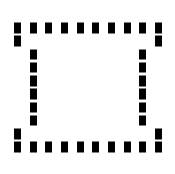

In [19]:
shape = 'shape4'
dirFROM = "ShapeGroups Gray/" + shape
num_samples = len(os.listdir(dirFROM))
print(num_samples)
set3 = np.empty([num_samples, 10,10])
for root, dirs, files in os.walk(dirFROM):
    idx = 0
    for file in files:
        pathFROM = root + '\\' + file
        pathFROM = pathFROM.replace('\\', '/')
        # pathTO = dirTO + '/' + pathFROM[17:]
        if pathFROM.find(shape) != -1:
            im = toGray(cv2.imread(pathFROM), 10, 10)
            set3[idx] = im
            idx = idx + 1
set3SC = np.copy(set3)
for sample_idx in range(np.shape(set3)[0]):
    set3SC[sample_idx] = SpatialContrast(set3[sample_idx])

# get min spikes per row
min_row_spikes = np.ones(shape=[np.shape(set3SC)[1]])*10
min_shape = np.zeros_like(set3SC[0])
for sample_idx in range(np.shape(set3SC)[0]):
    for col in range(np.shape(set3SC)[1]):
        num_row_spikes = 0
        for row in range(np.shape(set3SC)[2]):
            if set3SC[sample_idx][col][row] == 0:
                num_row_spikes = num_row_spikes + 1
        if 0 < num_row_spikes < min_row_spikes[col]:
            min_row_spikes[col] = num_row_spikes
            min_shape[col] = set3SC[sample_idx][col]

print(min_row_spikes)

set3_picked = []
for idx in range(20):
    set3_picked.append(np.ndarray.tolist(min_shape))

# print(len(set3_picked))
# set_mean = np.sum(set3SC, axis=0) / np.shape(set3SC)[0]
# set_meansq = np.sum(set3SC**2, axis=0) / np.shape(set3SC)[0]
# set_std = np.sqrt(set_meansq - set_mean**2)
# set3SCnew = np.copy(set3SC)
# set3_z = []
# print(set_std.astype(int))
# print()
# ax = plt.axes()
# plt.imshow(SpatialContrast(set_mean), cmap='gray')
# ax.axis('tight')
# ax.axis('off')
# fig = plt.gcf()
# fig.set_size_inches(2, 2)
# plt.show()

#
# for sample_idx in range(np.shape(set3)[0]):
#     sample_z = np.divide(set3SC[sample_idx] - set_mean, set_std)
#     for col in range(np.shape(set3)[1]):
#         for row in range(np.shape(set3)[2]):
#             if np.isnan(sample_z[col][row]) or np.isinf(sample_z[col][row]):
#                 sample_z[col][row] = 0
#     # print(abs(np.mean(sample_z)))
#     if np.mean(sample_z) <= 0:
#         set3_picked.append(np.ndarray.tolist(set3SC[sample_idx]))
#         set3_z.append(abs(np.mean(sample_z)))
#
# convert to spike set
all_spikes = []
for sample in set3_picked:
    time_step = 100
    spikes = []
    for col in range(np.shape(sample)[0]):
        row_spikes = []
        for row in range(np.shape(sample)[1]):
            if sample[col][row] == 0:
                row_spikes.append(row*time_step)
            else:
                sample[col][row] = 128
        spikes.append(row_spikes)
    all_spikes.append(spikes)

for sample_idx in range(len(set3_picked)):
    if sample_idx < 1:
        fig, ax = plt.subplots()
        plt.eventplot(all_spikes[sample_idx], linelengths=.8, linewidths=5, colors=['black'])
        ax.invert_yaxis()
        ax.set_facecolor('white')
        ax.set_yticks(range(10))
        ax.axis('tight')
        ax.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(2, 2)


with open("spike_set4_min.bin", "wb") as output:
    pickle.dump(all_spikes, output)

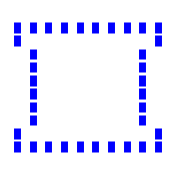

In [20]:
with open("spike_set_min/spike_set4_min.bin", "rb") as data:
    datain4 = pickle.load(data)[0]
# fig, ax = plt.subplots()
# plt.eventplot(datain0, linelengths=.8, linewidths=5, colors=['red'])
# ax.invert_yaxis()
# ax.set_facecolor('white')
# ax.set_yticks(range(10))
# ax.axis('tight')
# ax.axis('off')
# fig = plt.gcf()
# fig.set_size_inches(2, 2)
#
# with open("spike_set1_min.bin", "rb") as data:
#     datain1 = pickle.load(data)[0]
# # fig, ax = plt.subplots()
# # plt.eventplot(datain1, linelengths=.8, linewidths=5, colors=['red'])
# # ax.invert_yaxis()
# # ax.set_facecolor('white')
# # ax.set_yticks(range(10))
# # ax.axis('tight')
# # ax.axis('off')
# # fig = plt.gcf()
# # fig.set_size_inches(2, 2)
#
# with open("spike_set2_min.bin", "rb") as data:
#     datain2 = pickle.load(data)[0]
# # fig, ax = plt.subplots()
# # plt.eventplot(datain2, linelengths=.8, linewidths=5, colors=['red'])
# # ax.invert_yaxis()
# # ax.set_facecolor('white')
# # ax.set_yticks(range(10))
# # ax.axis('tight')
# # ax.axis('off')
# # fig = plt.gcf()
# # fig.set_size_inches(2, 2)
#
# with open("spike_set3_min.bin", "rb") as data:
#     datain3 = pickle.load(data)[0]
# # fig, ax = plt.subplots()
# # plt.eventplot(datain3, linelengths=.8, linewidths=5, colors=['red'])
# # ax.invert_yaxis()
# # ax.set_facecolor('white')
# # ax.set_yticks(range(10))
# # ax.axis('tight')
# # ax.axis('off')
# # fig = plt.gcf()
# # fig.set_size_inches(2, 2)
#
# with open("spike_set4_min.bin", "rb") as data:
#     datain4 = pickle.load(data)[0]
# # fig, ax = plt.subplots()
# # plt.eventplot(datain4, linelengths=.8, linewidths=5, colors=['red'])
# # ax.invert_yaxis()
# # ax.set_facecolor('white')
# # ax.set_yticks(range(10))
# # ax.axis('tight')
# # ax.axis('off')
# # fig = plt.gcf()
# # fig.set_size_inches(2, 2)
#
# with open("spike_set5_min.bin", "rb") as data:
#     datain5 = pickle.load(data)[0]
# # fig, ax = plt.subplots()
# # plt.eventplot(datain5, linelengths=.8, linewidths=5, colors=['red'])
# # ax.invert_yaxis()
# # ax.set_facecolor('white')
# # ax.set_yticks(range(10))
# # ax.axis('tight')
# # ax.axis('off')
# # fig = plt.gcf()
# # fig.set_size_inches(2, 2)

fig, ax = plt.subplots()
plt.eventplot(datain4, linelengths=.8, linewidths=5, colors=['blue'])
# plt.eventplot(datain3, linelengths=.8, linewidths=5, colors=['red'])
ax.invert_yaxis()
ax.set_facecolor('white')
ax.set_yticks(range(10))
ax.axis('tight')
ax.axis('off')
fig = plt.gcf()
fig.set_size_inches(2, 2)

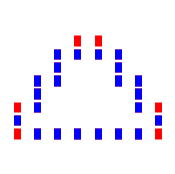

In [102]:

with open("spike sets/spike_set0.bin", "rb") as data:
    datain_1 = pickle.load(data)

datain_1 = datain_1[int(np.floor(.8*len(datain_1))+1):]
fig, ax = plt.subplots()
plt.eventplot(datain_1[0], linelengths=.8, linewidths=5, colors=['red'])
plt.eventplot(datain0, linelengths=.8, linewidths=5, colors=['blue'])
ax.invert_yaxis()
ax.set_facecolor('white')
ax.set_yticks(range(10))
ax.axis('tight')
ax.axis('off')
fig = plt.gcf()
fig.set_size_inches(2, 2)